# PACE Rapid Response Workflow

This Jupyter notebook serves as the first of hopefully many examples to rapidly access, download, review, and develop science data products is support of the NASA PACE Mission. In this notebook we investigate the impacts of Hurricane Erin that formed in mid-August of 2025. In particular we attempt to analyze different ecologically relevant biogeochemical parameters before and after the extreme strom off the southeastern shore of the United States.

Scientific Premise: "Remotely sensed ocean color shows increased concentrations of surface chlorophyll within the cool wakes of the hurricanes, apparently in response to the injection of nutrients and/or biogenic pigments into the oligotrophic surface waters. This increase in post-storm surface chlorophyll concentration usually lasted 2–3 weeks before it returned to its nominal pre-hurricane levels" Citation: https://doi.org/10.1029/2003JC001938

Graham Trolley & Matthew Kehrli

NASA Ocean Ecology Laboratory

September 2025

### Case Study Information

Hurricane Erin, look at chl-a before and after hurricane off FL coast.Hurricanes tend to increase productivity

Timeline (using worldview): 
- Hurricane off florida/gulf stream PACE imagery on AUG 20
- Aug 21, hurricane passed and clear imagery
- Aug 18/19 hurricane not there yet

*post Aug 21, there is a PACE safehold so no data. But, the imagery from Aug21 immediately post hurricane is enough for this example script


### Basic Steps
- Use worldview to identify an event and region of interest to examine (basic before/after)
- define lat lon bounds, and time range for pre- and post-event averages
- earthdata search using parameters. Open the first one by itself to establish gridding params
- use dask to open all the pre-event granules
- use dask to open all the post-event granules
- make some initial analysis plots
- return pre and post dataframes to user, to allow them to make more custom plots

### Imports

In [1]:
import cartopy.crs as ccrs
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.colors import LogNorm
import cmocean
from dask.distributed import Client
from matplotlib.patches import Rectangle
import os

### User Defined Functions

In [2]:
# Define Functions, don't modify
def grid_match(path, dst_crs, dst_shape, dst_transform, variable):
    """Reproject a Level-2 granule to match a Level-3M-ish granule."""
    dt = xr.open_datatree(path)
    da = dt["geophysical_data"][variable]
    da = da.rio.set_spatial_dims("pixels_per_line", "number_of_lines")
    da = da.rio.set_crs("epsg:4326")
    da = da.rio.reproject(
        dst_crs,
        shape=dst_shape,
        transform=dst_transform,
        src_geoloc_array=(
            dt["navigation_data"]["longitude"],
            dt["navigation_data"]["latitude"],
        ),
    )
    da = da.rename({"x":"longitude", "y":"latitude"})
    return da

def time_from_attr(ds):
    """Set the start time attribute as a dataset variable.
 
    Parameters
    ----------
    ds
        a dataset corresponding to a Level-2 granule
    """
    datetime = ds.attrs["time_coverage_start"].replace("Z", "")
    ds["time"] = ((), np.datetime64(datetime, "ns"))
    ds = ds.set_coords("time")
    return ds

### User Inputs: Processing Parameters

In [ ]:
# User definitions:

pre_tspan = ("2025-08-18", "2025-08-20")    # define your pre-event and post-event timespans
post_tspan = ("2025-08-21", "2025-08-22")

min_lon = -82       # Set lat/lon extent for area of interest
min_lat = 27.8
max_lon = -70
max_lat = 32.1

suite_name="PACE_OCI_L2_BGC_NRT" # oci suite name
var_name = "chlor_a" # variable of interest

in_the_cloud = False # set to true if running in cloud (e.g. Cryocloud), false if running locally. For speed, granules will be downloaded to a local_data directory when set to false

In [4]:
'''One large cell to load in all relevant pre-event and post-event granules
Steps:
- Earth access search to make lists of pre and post event files
- Open first entry of list manually, manipulate to L3M-like format and store relevant grid configuration info
- Using dask, open pre and post event granules, recast to L3M-like mapped format, trim to spatial extent, combine 2 datasets
- Make some default plots to visualize Pre and Post event data
'''

bbox = (min_lon, min_lat, max_lon, max_lat)
if in_the_cloud == False:
    os.makedirs('local_data/', exist_ok=True)# if not in the cloud, make a folder to downlad granules to. This folder is configured to not be tracked in the gitignore

pre_results = earthaccess.search_data(
    short_name=suite_name,
    temporal=pre_tspan,
    bounding_box=bbox,
)
print(" Number of pre-event granules: "+str(len(pre_results)))

post_results = earthaccess.search_data(
    short_name=suite_name,
    temporal=post_tspan,
    bounding_box=bbox,
)
print(" Number of post-event granules: "+str(len(post_results)))

# in running this script in the cloud, earthaccess.open is fast, but when running locally it takes a long time (10+ min), and locally downloading the data is faster.
# so, get the data with different approaches, depening on whether you are in the cloud or not, defined above
if in_the_cloud == True:
    pre_paths = earthaccess.open(pre_results, local_path="data")
    post_paths = earthaccess.open(post_results, local_path="data")
else:
    pre_paths = earthaccess.download(pre_results, local_path="local_data/")
    post_paths = earthaccess.download(post_results, local_path="local_data/")
    print('Files Downloaded')


# Part 1: load first file in pre_paths, manipulate to L3M-like, store geo info

datatree = xr.open_datatree(pre_paths[0])
dataset = xr.merge(datatree.to_dict().values())
dataset = dataset.set_coords(("longitude", "latitude"))

var_data = dataset[var_name]# use code from dask_gridding notebook to transform L2 granule to L3M-like grid
var_data = var_data.rio.set_spatial_dims("pixels_per_line", "number_of_lines")
var_data = var_data.rio.write_crs("epsg:4326")
var_L3M = var_data.rio.reproject(
    dst_crs="epsg:4326",
    src_geoloc_array=(
        var_data.coords["longitude"],
        var_data.coords["latitude"],
    ),
)
var_L3M = var_L3M.rename({"x":"longitude", "y":"latitude"})

var_L3M_aoi = var_L3M.sel({"longitude": slice(bbox[0], bbox[2]),"latitude": slice(bbox[3], bbox[1])})

crs = var_L3M_aoi.rio.crs# set mapping parameters from newly transformed file, to use when opening the rest with dask
shape = var_L3M_aoi.rio.shape
transform = var_L3M_aoi.rio.transform()

# part 2: using dask, open all the data in pre_paths and post_paths
# 2a load pre event files
client = Client()
pre_futures = client.map(grid_match,pre_paths,dst_crs=crs,dst_shape=shape,dst_transform=transform, variable = var_name)
kwargs = {"combine": "nested", "concat_dim": "time"}
pre_attrs = xr.open_mfdataset(pre_paths, preprocess=time_from_attr, **kwargs)
pre_data = xr.combine_nested(client.gather(pre_futures), concat_dim="time")# open  all pre files. they are stored in same xarray dataset at different "time" coordinates 
pre_data["time"] = pre_attrs["time"]
client.close()
print('loaded pre event files')

# 2b post event files
client = Client()
post_futures = client.map(grid_match,post_paths,dst_crs=crs,dst_shape=shape,dst_transform=transform, variable = var_name)
kwargs = {"combine": "nested", "concat_dim": "time"}
post_attrs = xr.open_mfdataset(post_paths, preprocess=time_from_attr, **kwargs)
post_data = xr.combine_nested(client.gather(post_futures), concat_dim="time")# open all post files. they are stored in same xarray dataset at different "time" coordinates 
post_data["time"] = post_attrs["time"]
client.close()
print('loaded post event files')

 Number of pre-event granules: 5
 Number of post-event granules: 2


QUEUEING TASKS | :   0%|          | 0/5 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/5 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/5 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

Files Downloaded


C:\Users\gtrolley\AppData\Local\Temp\ipykernel_21012\1504549567.py:40: FutureWarning: In a future version, xarray will not decode the variable 'day' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  datatree = xr.open_datatree(pre_paths[0])
C:\Users\gtrolley\AppData\Local\Temp\ipykernel_21012\1504549567.py:40: FutureWarning: In a future version, xarray will not decode the variable 'msec' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is 

loaded pre event files
loaded post event files


Text(0.5, 1.0, 'post_hurricane 8/21')

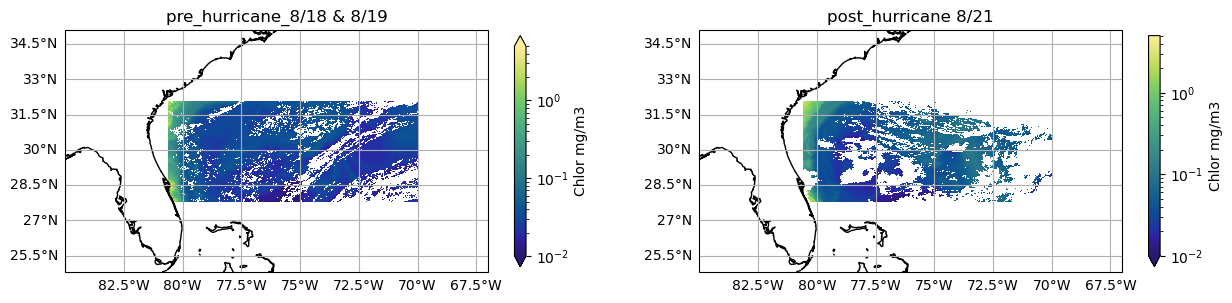

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax[0].gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = pre_data.mean("time").plot(x="longitude", y="latitude" , cbar_kwargs={'label': 'Chlor mg/m3', 'shrink':0.5}, cmap=cmocean.cm.haline,norm=LogNorm(vmin=.01, vmax=5),  ax=ax[0], robust=True)
ax[0].set_xlim(bbox[0]-3,bbox[2]+3,)
ax[0].set_ylim(bbox[1]-3,bbox[3]+3)
ax[0].coastlines()
ax[0].set_title('pre_hurricane_8/18 & 8/19')


ax[1].gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = post_data.mean("time").plot(x="longitude", y="latitude", cbar_kwargs={'label': 'Chlor mg/m3', 'shrink':0.5}, cmap=cmocean.cm.haline,norm=LogNorm(vmin=.01, vmax=5),  ax=ax[1], robust=True)
ax[1].set_xlim(bbox[0]-3,bbox[2]+3,)
ax[1].set_ylim(bbox[1]-3,bbox[3]+3)
ax[1].coastlines()
ax[1].set_title('post_hurricane 8/21')


Text(0.5, 1.0, 'Percent Change in Chlorphyll-a')

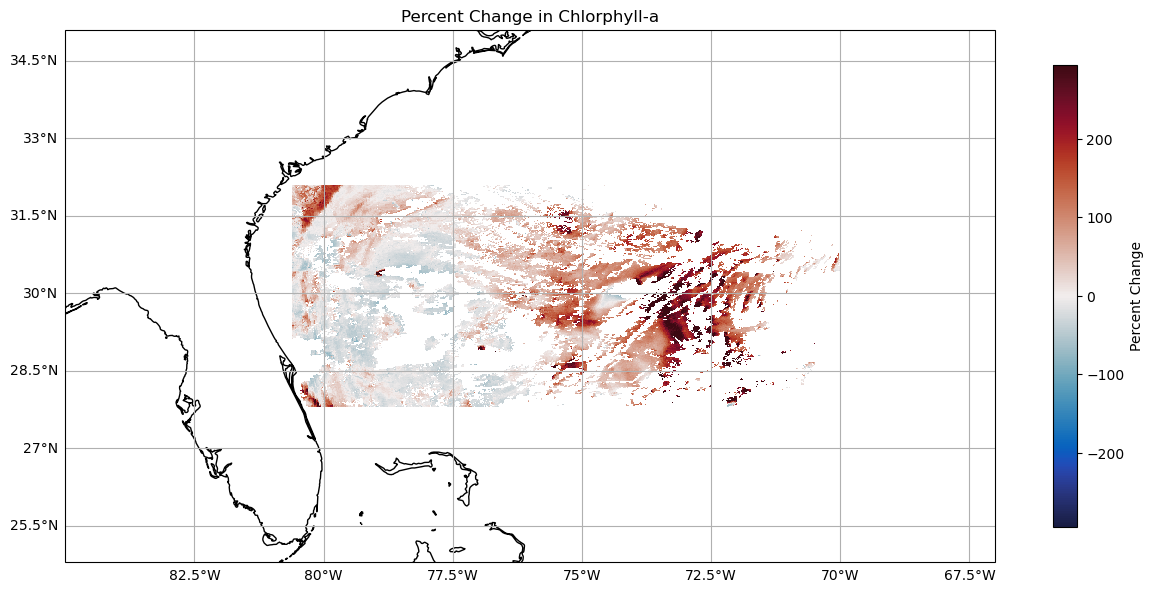

In [6]:
# compare the pre and post event data. first, mask both to only pixels where data is available before and after the hurricane
# then, mask each where it's values are greater or less than

pre_mean = pre_data.mean("time")
post_mean = post_data.mean("time")

post_mean['longitude'] = post_mean['longitude'].round(5)# round lat/lon to 5 decimals, was having issues with floats at large # of decimals not being exactly the same
post_mean['latitude'] = post_mean['latitude'].round(5)
pre_mean['longitude'] = pre_mean['longitude'].round(5)
pre_mean['latitude'] = pre_mean['latitude'].round(5)

# Create a mask where both datasets have valid values
mask = ~np.isnan(post_mean) & ~np.isnan(pre_mean)

# Apply mask to both datasets
post_mean_mask = post_mean.where(mask)
pre_mean_mask = pre_mean.where(mask)

post_greater = (post_mean_mask-pre_mean_mask)/pre_mean_mask * 100

fig, ax = plt.subplots( figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = post_greater.plot(x="longitude", y="latitude" , cbar_kwargs={'label': 'Percent Change', 'shrink':0.5}, cmap=cmocean.cm.balance, extend = "neither", ax=ax, robust=True)
ax.set_xlim(bbox[0]-3,bbox[2]+3,)
ax.set_ylim(bbox[1]-3,bbox[3]+3)
ax.coastlines()
ax.set_title('Percent Change in Chlorphyll-a')


In [8]:
# Optional Secondary Analysis: POC. We can change the var_name variable to another parameter within the same
# product suite, and rerun the second-half of the processing code to repeat the analysis

var_name='poc'

# part 2: using dask, open all the data in pre_paths and post_paths
# 2a load pre event files
client = Client()
pre_futures = client.map(grid_match,pre_paths,dst_crs=crs,dst_shape=shape,dst_transform=transform, variable = var_name)
kwargs = {"combine": "nested", "concat_dim": "time"}
pre_attrs = xr.open_mfdataset(pre_paths, preprocess=time_from_attr, **kwargs)
pre_data_poc = xr.combine_nested(client.gather(pre_futures), concat_dim="time")# open  all pre files. they are stored in same xarray dataset at different "time" coordinates 
pre_data_poc["time"] = pre_attrs["time"]
client.close()
print('loaded pre event files')

# 2b post event files
client = Client()
post_futures = client.map(grid_match,post_paths,dst_crs=crs,dst_shape=shape,dst_transform=transform, variable = var_name)
kwargs = {"combine": "nested", "concat_dim": "time"}
post_attrs = xr.open_mfdataset(post_paths, preprocess=time_from_attr, **kwargs)
post_data_poc = xr.combine_nested(client.gather(post_futures), concat_dim="time")# open all post files. they are stored in same xarray dataset at different "time" coordinates 
post_data_poc["time"] = post_attrs["time"]
client.close()
print('loaded post event files')

loaded pre event files
loaded post event files


Text(0.5, 1.0, 'post_hurricane 8/21')

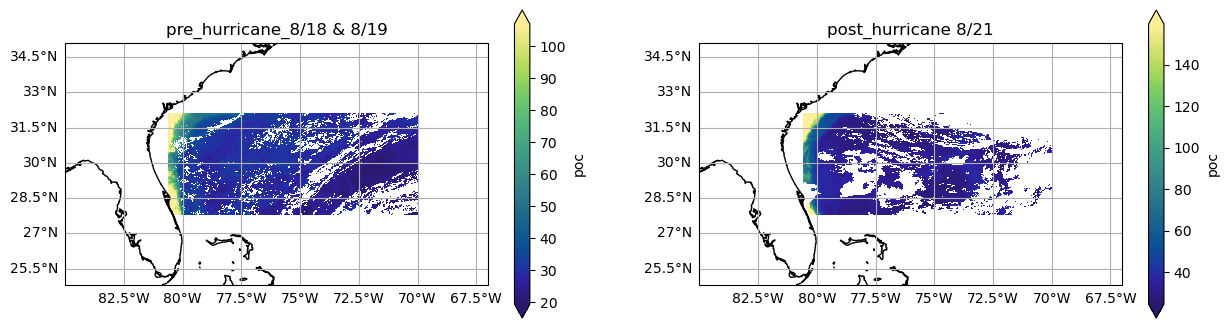

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), subplot_kw={'projection': ccrs.PlateCarree()})
ax[0].gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = pre_data_poc.mean("time").plot(x="longitude", y="latitude" , cmap=cmocean.cm.haline,  ax=ax[0], robust=True)
ax[0].set_xlim(bbox[0]-3,bbox[2]+3,)
ax[0].set_ylim(bbox[1]-3,bbox[3]+3)
ax[0].coastlines()
ax[0].set_title('pre_hurricane_8/18 & 8/19')


ax[1].gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = post_data_poc.mean("time").plot(x="longitude", y="latitude", cmap=cmocean.cm.haline,  ax=ax[1], robust=True)
ax[1].set_xlim(bbox[0]-3,bbox[2]+3,)
ax[1].set_ylim(bbox[1]-3,bbox[3]+3)
ax[1].coastlines()
ax[1].set_title('post_hurricane 8/21')

Text(0.5, 1.0, 'Percent Change in POC')

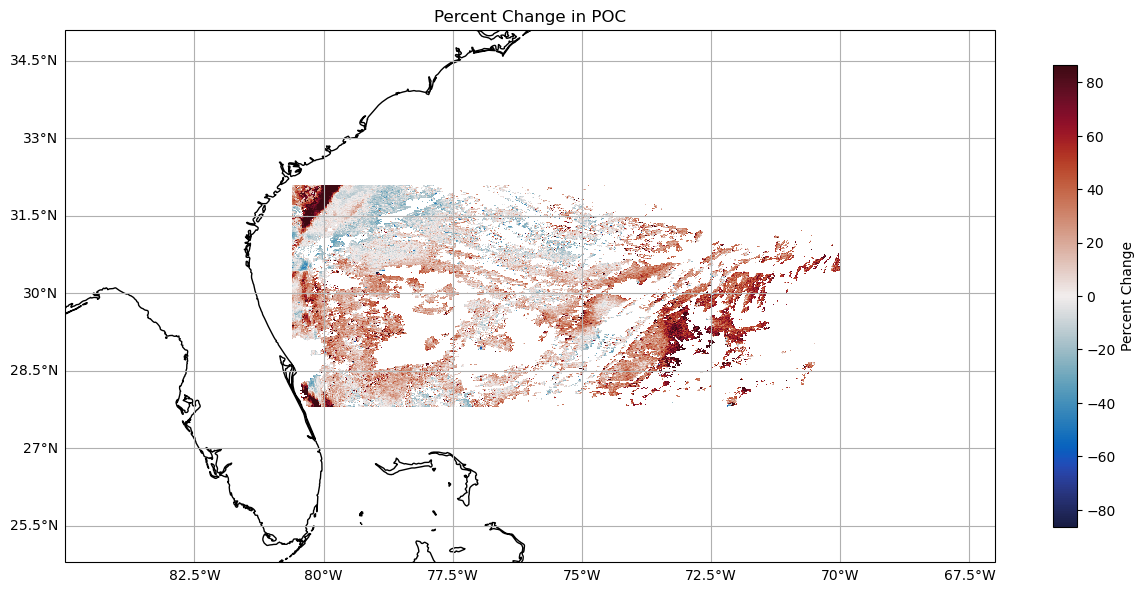

In [12]:
# compare the pre and post event data. first, mask both to only pixels where data is available before and after the hurricane
# then, mask each where it's values are greater or less than

pre_mean_poc = pre_data_poc.mean("time")
post_mean_poc = post_data_poc.mean("time")

post_mean_poc['longitude'] = post_mean_poc['longitude'].round(5)# round lat/lon to 5 decimals, was having issues with floats at large # of decimals not being exactly the same
post_mean_poc['latitude'] = post_mean_poc['latitude'].round(5)
pre_mean_poc['longitude'] = pre_mean_poc['longitude'].round(5)
pre_mean_poc['latitude'] = pre_mean_poc['latitude'].round(5)

# Create a mask where both datasets have valid values
mask = ~np.isnan(post_mean_poc) & ~np.isnan(pre_mean_poc)

# Apply mask to both datasets
post_mean_mask_poc = post_mean_poc.where(mask)
pre_mean_mask_poc = pre_mean_poc.where(mask)

post_greater = (post_mean_mask_poc-pre_mean_mask_poc)/pre_mean_mask_poc * 100

fig, ax = plt.subplots( figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = post_greater.plot(x="longitude", y="latitude" , cbar_kwargs={'label': 'Percent Change', 'shrink':0.5}, cmap=cmocean.cm.balance, extend = "neither", ax=ax, robust=True)
ax.set_xlim(bbox[0]-3,bbox[2]+3,)
ax.set_ylim(bbox[1]-3,bbox[3]+3)
ax.coastlines()
ax.set_title('Percent Change in POC')

